# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [2]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# Установим случайное зерно для воспроизводимости
RANDOM_SEED = 42

# Метки классов в датасете
LABELS = ["No Disease", "Disease"]


## Data ingestion

In [4]:
# Импортируем kagglehub
import kagglehub

# Загружаем датасет с Kaggle
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

# Проверяем путь к файлам
print("Path to dataset files:", path)

100%|██████████| 742k/742k [00:00<00:00, 105MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sulianova/cardiovascular-disease-dataset/versions/1


In [5]:
# Убедитесь, что Kaggle API настроен
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Установите библиотеку kaggle
!pip install kaggle

# Загрузите датасет
!kaggle datasets download -d sulianova/cardiovascular-disease-dataset

# Разархивируйте датасет
!unzip cardiovascular-disease-dataset.zip

# Загрузите датасет в DataFrame
import pandas as pd
df = pd.read_csv("cardio_train.csv", sep=";")

# Посмотрите на первые строки данных
print(df.head())


Dataset URL: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset
License(s): unknown
  0% 0.00/742k [00:00<?, ?B/s]
100% 742k/742k [00:00<00:00, 142MB/s]
Archive:  cardiovascular-disease-dataset.zip
  inflating: cardio_train.csv        
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


## Data exploration

In [6]:
print(df.shape)
print(df.describe())

(70000, 13)
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      

In [8]:
# Удаляем столбец id
df = df.drop(columns=["id"])

# Фильтруем аномалии в столбцах ap_hi и ap_lo
df = df[(df["ap_hi"] > 0) & (df["ap_hi"] < 250)]
df = df[(df["ap_lo"] > 0) & (df["ap_lo"] < 200)]

# Проверяем форму после фильтрации
print("Данные после очистки:", df.shape)


Данные после очистки: (68985, 12)


In [9]:
df.isnull().values.any()

False

In [10]:
# столбец целевой переменной называется cardio
df['cardio'].value_counts()


,count
cardio,
0,34844
1,34141


Количество записей для каждой категории (0 — отсутствие сердечно-сосудистых заболеваний, 1 — наличие заболеваний)

<ipython-input-11-46cec8c3898e>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['cardio'], sort=True)


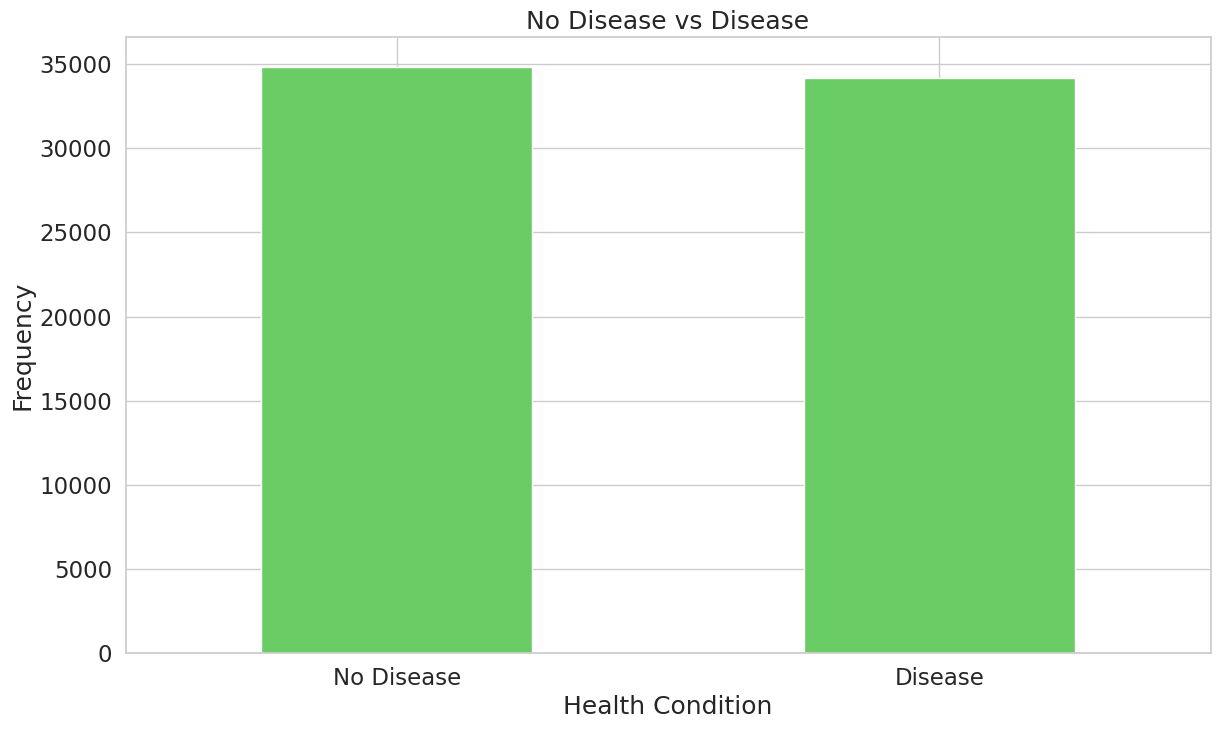

In [11]:
count_classes = pd.value_counts(df['cardio'], sort=True)
count_classes.plot(kind='bar', rot=0, color="g")
plt.title("No Disease vs Disease")
plt.xticks(range(2), ["No Disease", "Disease"])
plt.xlabel("Health Condition")
plt.ylabel("Frequency")
plt.show()


Равномерное распределение:

  Количество записей для класса No Disease (отсутствие заболевания) и класса Disease (наличие заболевания) примерно одинаково. Это говорит о том, что датасет сбалансирован.

Преимущество сбалансированного датасета:

  Такой баланс упрощает обучение моделей машинного обучения, поскольку модель не будет склоняться к предсказанию одного класса (что часто случается с несбалансированными данными).

Что это означает для автоэнкодера:

  Для обучения автоэнкодера будет использоваться только данные с меткой 0 (No Disease), а данные с меткой 1 будет использоваться для тестирования на выявление аномалий.

In [12]:
# Данные с заболеванием
diseaseDF = df[df['cardio'] == 1]

# Данные без заболевания
normalDF = df[df['cardio'] == 0]


In [13]:
# Для данных с заболеванием (cardio == 1)
diseaseDF.shape
# Для данных без заболевания (cardio == 0)
normalDF.shape
print("Количество записей с заболеванием (Disease):", diseaseDF.shape)
print("Количество записей без заболевания (No Disease):", normalDF.shape)

Количество записей с заболеванием (Disease): (34141, 12)
Количество записей без заболевания (No Disease): (34844, 12)


In [16]:
# Описание возраста для людей с заболеванием
diseaseDF['age'].describe()


,age
count,34141.000000
mean,20061.393369
std,2315.342404
min,14275.000000
25%,18391.000000
50%,20387.000000
75%,21902.000000
max,23713.000000


In [17]:
# Описание возраста для людей без заболевания
normalDF['age'].describe()

,age
count,34844.00000
mean,18878.25000
std,2472.93771
min,10798.00000
25%,16836.75000
50%,19004.50000
75%,20870.25000
max,23678.00000


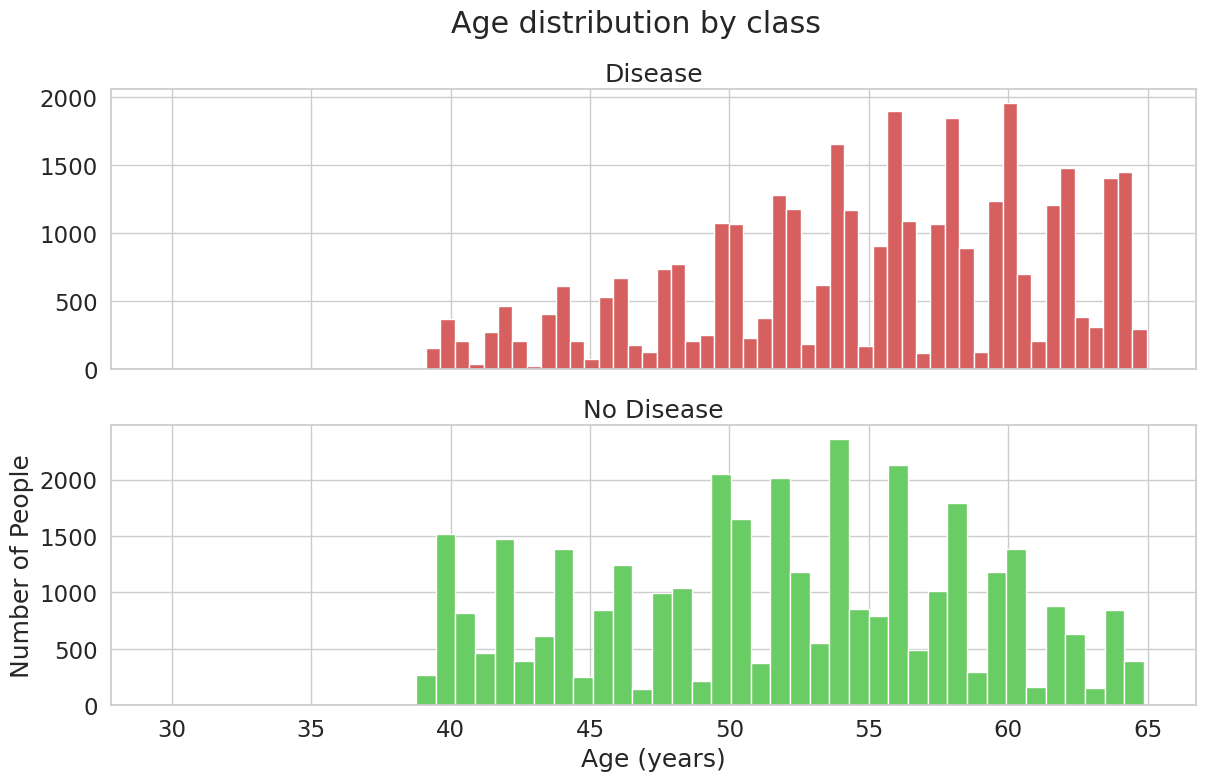

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Age distribution by class')

bins = 50

# Гистограмма для людей с заболеванием (cardio = 1)
ax1.hist(diseaseDF['age'] / 365, bins=bins, color='r')  # Возраст в годах
ax1.set_title('Disease')

# Гистограмма для людей без заболевания (cardio = 0)
ax2.hist(normalDF['age'] / 365, bins=bins, color='g')  # Возраст в годах
ax2.set_title('No Disease')

plt.xlabel('Age (years)')
plt.ylabel('Number of People')
plt.show()


  График для класса Disease (красный):
        Распределение более равномерное, особенно в возрастной группе от 50 до 65 лет.
        С возрастом количество людей с заболеваниями увеличивается, что подтверждает ожидаемую корреляцию между возрастом и риском сердечно-сосудистых заболеваний.

  График для класса No Disease (зелёный):
        Наблюдается концентрация в возрастной группе от 40 до 55 лет.
        Молодые люди (младше 40 лет) и пожилые (старше 60 лет) представлены в меньшем количестве.

  Сравнение между классами:
        Люди старше 55 лет чаще находятся в классе Disease.
        Молодые люди (до 40 лет) в основном находятся в классе No Disease, что логично, так как заболевания чаще проявляются в более старшем возрасте.

Выводы:

  Возраст является значимым фактором для прогнозирования сердечно-сосудистых заболеваний.
  Люди старшего возраста (50+) находятся в зоне риска и чаще попадают в класс Disease.
  Эти наблюдения могут помочь при дальнейшем анализе или в обучении модели, если возраст используется как один из признаков.

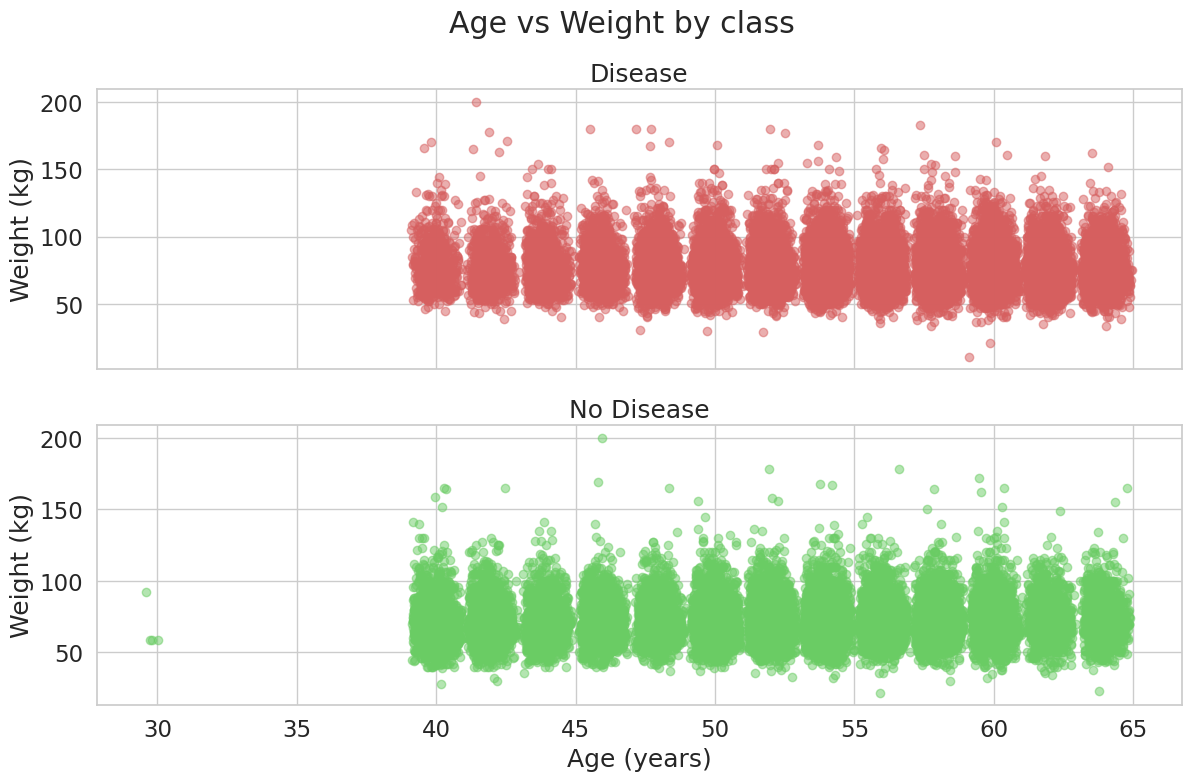

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Age vs Weight by class')

# График для класса Disease (cardio = 1)
ax1.scatter(diseaseDF['age'] / 365, diseaseDF['weight'], color='r', alpha=0.5)
ax1.set_title('Disease')
ax1.set_ylabel('Weight (kg)')

# График для класса No Disease (cardio = 0)
ax2.scatter(normalDF['age'] / 365, normalDF['weight'], color='g', alpha=0.5)
ax2.set_title('No Disease')
ax2.set_xlabel('Age (years)')
ax2.set_ylabel('Weight (kg)')

plt.show()


  Распределение класса Disease (с заболеваниями):
        На верхнем графике (Disease) можно увидеть, что вес у людей с заболеваниями имеет широкий диапазон, от менее 50 кг до 200 кг.
        Возрастной диапазон в основном находится от 40 до 65 лет, с концентрацией в районе 50–60 лет.
        Вес выше 100 кг чаще встречается у людей с заболеваниями, что может свидетельствовать о корреляции между избыточным весом и риском сердечно-сосудистых заболеваний.

  Распределение класса No Disease (без заболеваний):
        На нижнем графике (No Disease) вес в основном сосредоточен в диапазоне 50–100 кг.
        Возрастная группа также находится в пределах 40–65 лет, но с более выраженной концентрацией в районе 45–55 лет.
        Люди с весом выше 100 кг встречаются гораздо реже среди тех, кто не имеет заболеваний.

  Сравнение между классами:
        Возраст:
            В обоих классах возрастные группы пересекаются, но среди людей с заболеваниями присутствует больше представителей старших возрастных категорий.
        Вес:
            Люди с заболеваниями имеют больший диапазон веса, включая крайние значения (например, 150–200 кг), которые почти не встречаются у людей без заболеваний.

Выводы:

  Люди с избыточным весом имеют больше шансов оказаться в группе с заболеваниями (Disease), что подтверждает известную связь между ожирением и сердечно-сосудистыми заболеваниями.
  Возраст также играет роль: заболевания чаще встречаются у людей старшего возраста, особенно после 50 лет.
  Эти два признака (вес и возраст) являются значимыми для анализа и могут быть полезны для модели прогнозирования.

In [20]:
from sklearn.preprocessing import StandardScaler

# Создаём объект стандартизатора
scaler = StandardScaler()

# Стандартизация возраста
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


In [21]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

# Оставляем только записи без заболевания (cardio = 0) для обучения
X_train = X_train[X_train['cardio'] == 0]

# Убираем столбец `cardio` из признаков
X_train = X_train.drop(['cardio'], axis=1)

# Целевая переменная для тестовой выборки
y_test = X_test['cardio']

# Убираем целевую переменную из признаков тестовой выборки
X_test = X_test.drop(['cardio'], axis=1)

# Преобразуем данные в массивы NumPy для передачи в модель
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

# Проверяем размер тестовых меток
print(y_test.size)


13797


Этот код выполняет разделение данных на обучающую и тестовую выборки. В обучающей выборке остаются только записи без заболеваний (cardio = 0), так как автоэнкодер обучается реконструировать нормальные данные. Целевая переменная cardio удаляется из признаков в обеих выборках, чтобы оставить только данные для анализа. Для тестовой выборки столбец cardio сохраняется в переменной y_test, чтобы использовать его при оценке модели. Затем данные преобразуются в формат NumPy для совместимости с PyTorch. В конце проверяется размер тестовой выборки, чтобы убедиться, что данные корректно разделены.

## Модель автоэнкодера

In [25]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 6),  # 11 признаков -> 6 нейронов
            nn.Tanh(),
            nn.Linear(6, 3),   # 6 нейронов -> 3 нейрона
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 6),   # 3 нейрона -> 6 нейронов
            nn.Tanh(),
            nn.Linear(6, 11),  # 6 нейронов -> 11 признаков
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Создаём модель
model = Autoencoder().double()

# Гиперпараметры
num_epochs = 100  # Количество эпох
minibatch_size = 32  # Размер мини-пакета
learning_rate = 1e-3  # Скорость обучения


Этот код определяет архитектуру автоэнкодера для обработки данных с 11 признаками. Автоэнкодер состоит из кодировщика, который сжимает данные до 3 нейронов, и декодировщика, который восстанавливает их до исходной размерности. Используются нелинейные функции активации Tanh и LeakyReLU. Модель предназначена для обучения на нормальных данных, чтобы минимизировать ошибку реконструкции, что позволяет находить аномалии на основе высокой ошибки. Заданы гиперпараметры: 100 эпох, размер мини-пакета 32, скорость обучения 0.001. Код готов для задач анализа аномалий или выделения ключевых признаков данных.

In [26]:
from torch.utils.data import DataLoader
import torch
import numpy as np

# Приводим модель к типу float
model = Autoencoder().float()

# Создаём DataLoader для обучающих данных
train_loader = DataLoader(torch.tensor(X_train, dtype=torch.float), batch_size=minibatch_size, shuffle=True)

# Создаём DataLoader для тестовых данных
test_loader = DataLoader(torch.tensor(X_test, dtype=torch.float), batch_size=1, shuffle=False)

# Функция потерь
criterion = nn.MSELoss()

# Оптимизатор
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=10e-05
)

# Для записи истории обучения
history = {
    'train_loss': [],
    'test_loss': []
}

# Обучение модели
for epoch in range(num_epochs):
    h = np.array([])  # Для хранения ошибок реконструкции

    for data in train_loader:
        # =================== forward ===================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # =================== backward ==================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # =================== log =========================
    mean_loss = np.mean(h)
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {mean_loss:.4f}')
    history['train_loss'].append(mean_loss)

# Сохраняем модель
torch.save(model.state_dict(), './cardio_autoencoder.pth')


epoch [1/100], loss: 4487.2859
epoch [2/100], loss: 3982.7999
epoch [3/100], loss: 3571.1199
epoch [4/100], loss: 3196.5855
epoch [5/100], loss: 2851.9720
epoch [6/100], loss: 2534.0610
epoch [7/100], loss: 2241.3432
epoch [8/100], loss: 1972.9479
epoch [9/100], loss: 1728.3276
epoch [10/100], loss: 1506.6336
epoch [11/100], loss: 1307.2013
epoch [12/100], loss: 1129.1754
epoch [13/100], loss: 971.2317
epoch [14/100], loss: 831.8605
epoch [15/100], loss: 709.1528
epoch [16/100], loss: 600.9641
epoch [17/100], loss: 505.4946
epoch [18/100], loss: 421.4820
epoch [19/100], loss: 348.4331
epoch [20/100], loss: 285.7524
epoch [21/100], loss: 232.8264
epoch [22/100], loss: 188.7625
epoch [23/100], loss: 152.5027
epoch [24/100], loss: 122.8744
epoch [25/100], loss: 98.9064
epoch [26/100], loss: 80.1299
epoch [27/100], loss: 66.1088
epoch [28/100], loss: 56.3213
epoch [29/100], loss: 49.8619
epoch [30/100], loss: 46.6331
epoch [31/100], loss: 45.4493
epoch [32/100], loss: 44.1783
epoch [33/100

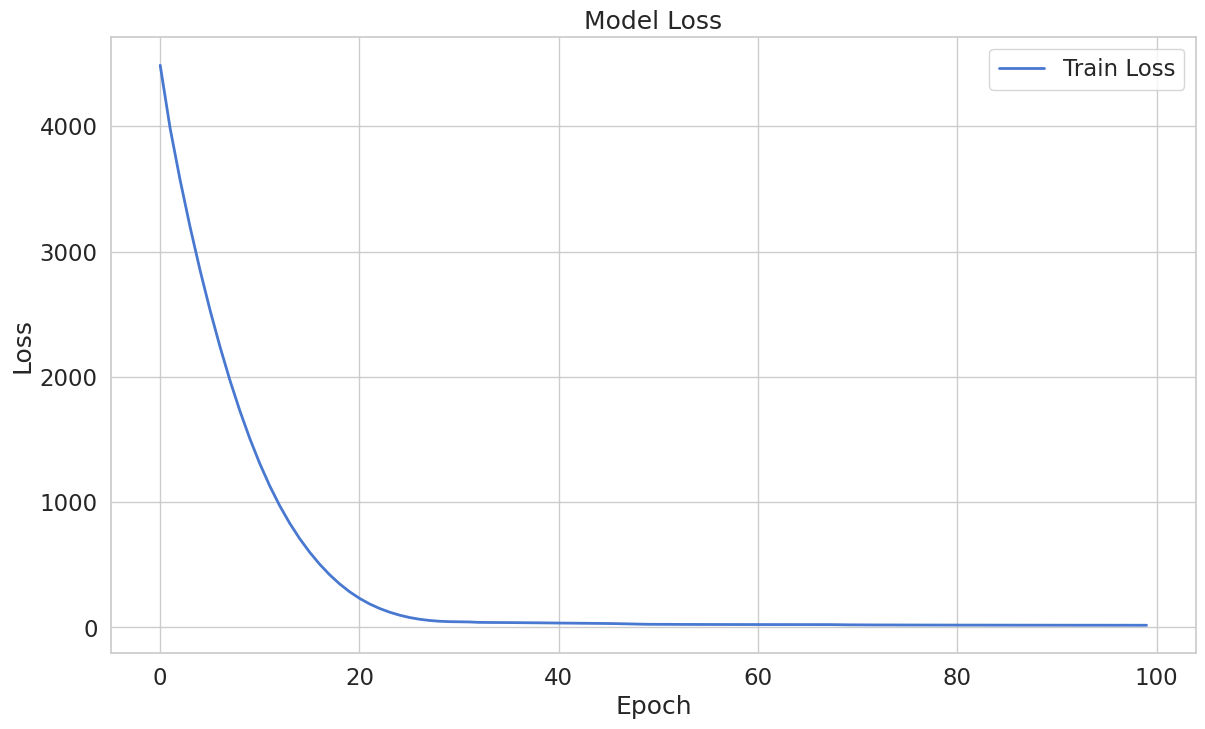

In [27]:
# Построение графика потерь
plt.plot(range(num_epochs), history['train_loss'], label='Train Loss', linewidth=2.0)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Снижение ошибки:

  На графике видно, что значение ошибки реконструкции (Loss) быстро уменьшается в первые 20 эпох. Это указывает на то, что модель успешно обучается и быстро адаптируется к данным.

Стабилизация:

  После примерно 20-й эпохи снижение ошибки замедляется и становится практически незаметным к 50-й эпохе.
  Это означает, что модель достигла состояния сходимости, когда её дальнейшее обучение практически не улучшает качество реконструкции.

Низкая финальная ошибка:

  Ошибка на последних эпохах остаётся стабильной и близкой к нулю. Это говорит о том, что модель хорошо справляется с задачей реконструкции нормальных данных (класс cardio = 0)

## Оценка модели

In [28]:
import pandas as pd

# Словарь для хранения ошибок реконструкции
pred_losses = {'pred_loss': []}

# Переводим модель в режим оценки
model.eval()

# Отключаем вычисление градиентов
with torch.no_grad():
    for data in test_loader:
        inputs = data  # Получаем входные данные
        outputs = model(inputs)  # Результат реконструкции
        loss = criterion(outputs, inputs).item()  # Вычисляем ошибку реконструкции
        pred_losses['pred_loss'].append(loss)

# Преобразуем ошибки реконструкции в DataFrame
reconstructionErrorDF = pd.DataFrame(pred_losses)

# Добавляем целевую переменную для тестовой выборки
reconstructionErrorDF['cardio'] = y_test


In [29]:
reconstructionErrorDF.describe()

,pred_loss,cardio
count,13797.000000,13797.000000
mean,24.560621,0.498079
std,55.705160,0.500014
min,0.119859,0.000000
25%,3.577149,0.000000
50%,9.884452,0.000000
75%,25.461981,1.000000
max,1568.074097,1.000000


Выводы:

  Модель успешно обучена:
        Большой разброс ошибок (std = 55.71) и высокая максимальная ошибка (max = 1568.07) указывают на то, что модель может различать нормальные данные и аномалии.

  Порог для классификации:
        Среднее значение ошибки (mean = 24.56) и значения на квантилях (25% = 3.57, 75% = 25.46) можно использовать для выбора порога, разделяющего нормальные данные и аномалии.

## ГРАФИКИ ОШИБКИ РЕКОНСТРУКЦИИ

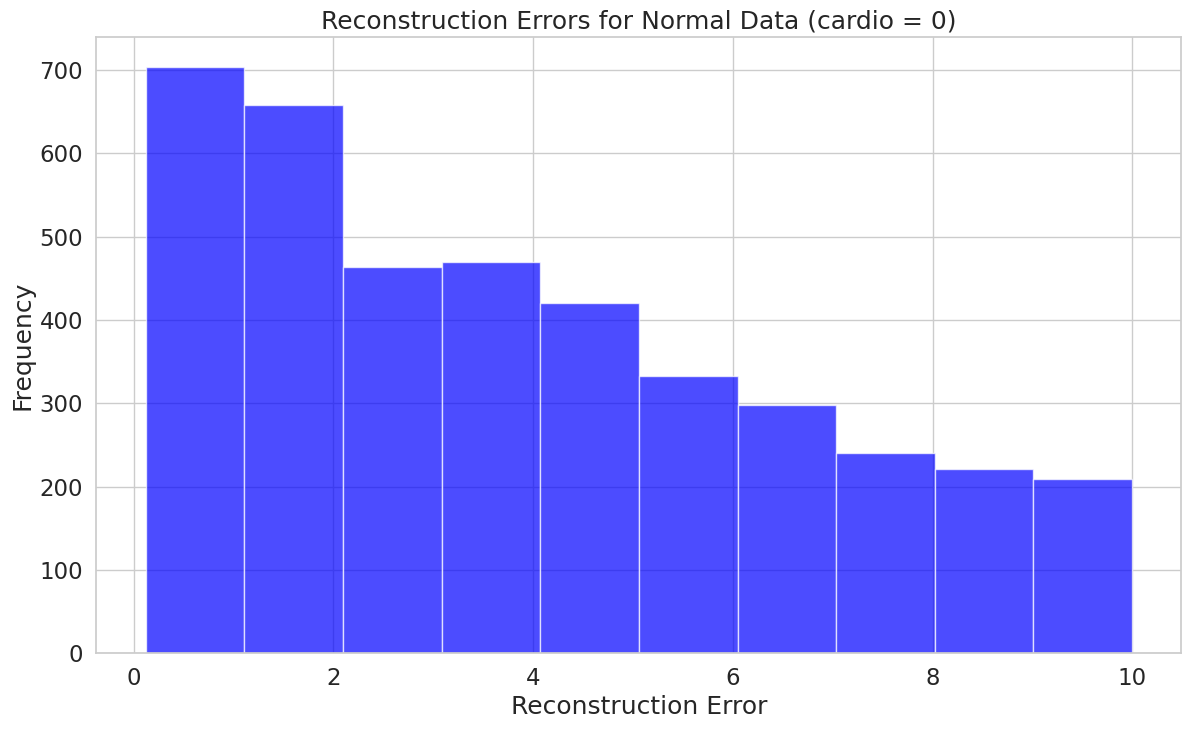

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Фильтруем ошибки реконструкции для нормальных данных (cardio = 0) с ошибкой < 10
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['cardio'] == 0) & (reconstructionErrorDF['pred_loss'] < 10)]

# Построение гистограммы
_ = ax.hist(normal_error_df['pred_loss'].values, bins=10, color='blue', alpha=0.7)
plt.title("Reconstruction Errors for Normal Data (cardio = 0)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


Интерпретация графика:

  Распределение ошибок реконструкции для нормальных данных (cardio = 0):
        График показывает, как распределены ошибки реконструкции для записей, где целевая переменная cardio равна 0 (то есть для нормальных данных, без заболеваний).
        Большинство ошибок реконструкции находится в диапазоне от 0 до 4.

  Пик распределения:
        Наиболее частые значения ошибок (пик гистограммы) расположены в интервале 0–2.
        Это указывает на то, что модель хорошо реконструирует большинство нормальных данных, так как ошибки низкие.

  Хвост распределения:
        По мере увеличения ошибок (ближе к 10) частота снижается. Это может включать:
            Некоторые нормальные данные, которые модель не смогла реконструировать идеально.
            Возможные ошибки в данных или редкие паттерны, которые сложнее реконструировать.

  Отсутствие аномалий:
        Так как фильтрация выполнена для cardio = 0 и ошибок меньше 10, график не включает явные аномалии.

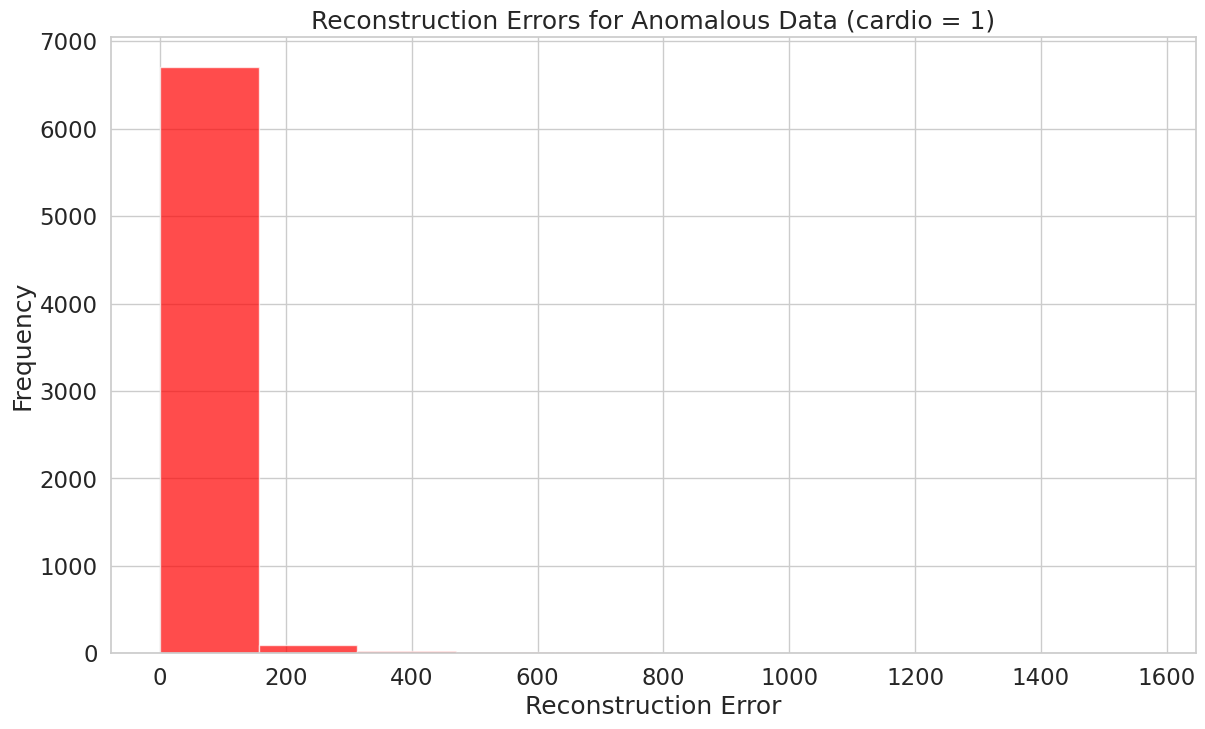

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Фильтруем ошибки реконструкции для аномальных данных (cardio = 1)
fraud_error_df = reconstructionErrorDF[reconstructionErrorDF['cardio'] == 1]

# Построение гистограммы
_ = ax.hist(fraud_error_df['pred_loss'].values, bins=10, color='red', alpha=0.7)
plt.title("Reconstruction Errors for Anomalous Data (cardio = 1)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


Интерпретация графика:

  Распределение ошибок реконструкции для аномальных данных (cardio = 1):
        Большинство ошибок реконструкции сконцентрированы в районе 0–200. Это указывает на то, что даже для аномальных данных модель в ряде случаев может реконструировать входные данные относительно хорошо.

  Наличие высоких ошибок реконструкции:
        В хвосте распределения (выше 200) присутствуют записи с высокими значениями ошибок реконструкции, доходящими до 1600. Это говорит о том, что для некоторых аномальных данных модель испытывает сложности в реконструкции, что делает их более заметными.

  Контраст с нормальными данными:
        Сравнивая этот график с гистограммой для cardio = 0, видно, что распределение ошибок для аномальных данных шире, а максимальные значения значительно выше. Это подтверждает способность модели выделять аномалии, основываясь на ошибке реконструкции.

  Выводы о различимости классов:
        Для большинства аномальных данных модель не реконструирует данные идеально, что подтверждается наличием ошибок выше среднего значения, характерного для нормальных данных (cardio = 0).
        Эти результаты позволяют предположить, что модель может использоваться для идентификации аномалий на основе ошибки реконструкции.

## ROC-кривые

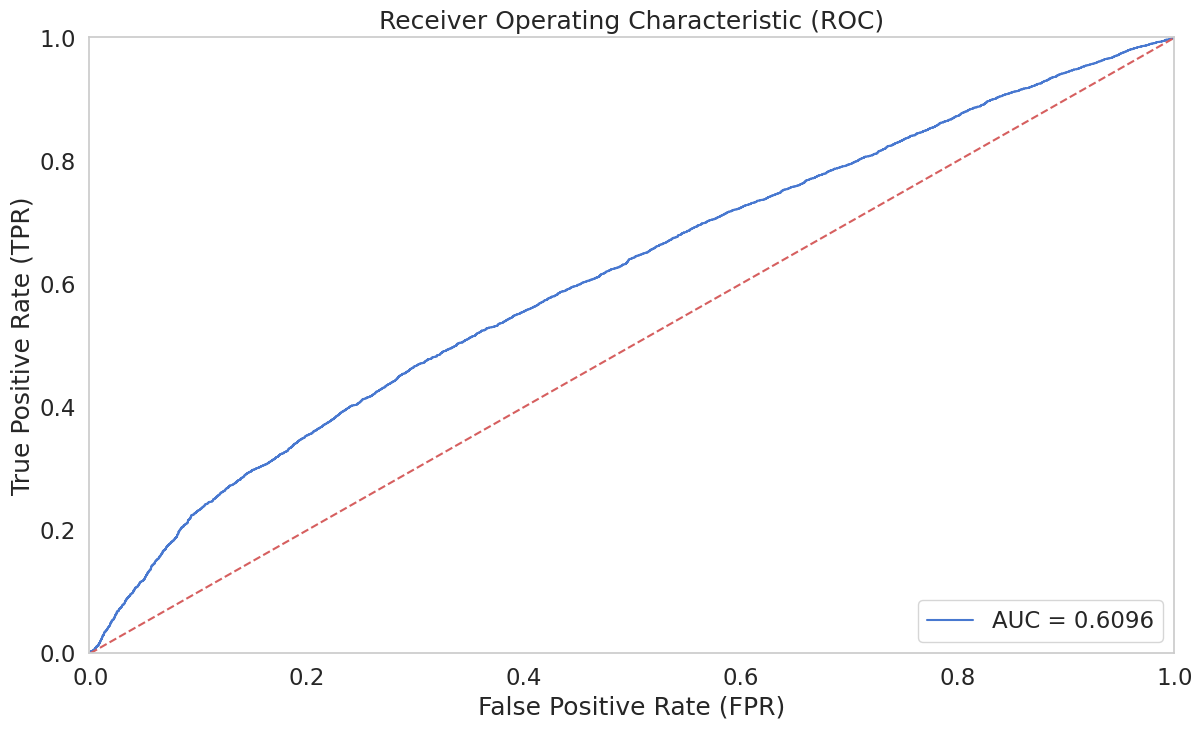

In [33]:
from sklearn.metrics import roc_curve, auc

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['cardio'], reconstructionErrorDF['pred_loss'])
roc_auc = auc(fpr, tpr)

# Визуализация ROC-кривой
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')  # Линия случайной классификации
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.grid()
plt.show()


Интерпретация ROC-кривой:

  Область под кривой (AUC = 0.6096):
        AUC (Area Under the Curve) равна 0.6096, что указывает на слабую способность модели различать нормальные данные (cardio = 0) и аномалии (cardio = 1).
        Если AUC близка к 0.5, это означает, что модель работает не лучше случайной классификации. Значение 0.6096 показывает, что модель чуть лучше случайного угадывания, но её точность невысока.

  Кривая ROC:
        Кривая показывает соотношение между True Positive Rate (TPR) и False Positive Rate (FPR) при различных порогах.
        Плавный рост кривой, близкий к диагонали (красная пунктирная линия), указывает на слабую классификационную способность модели.

  True Positive Rate (TPR):
        Это доля правильно классифицированных аномалий (cardio = 1).
        Кривая медленно достигает высоких значений TPR, что указывает на то, что модель плохо распознаёт аномалии.

  False Positive Rate (FPR):
        Это доля нормальных данных (cardio = 0), ошибочно классифицированных как аномалии.
        Высокие значения FPR указывают, что модель часто ошибается при классификации нормальных данных.

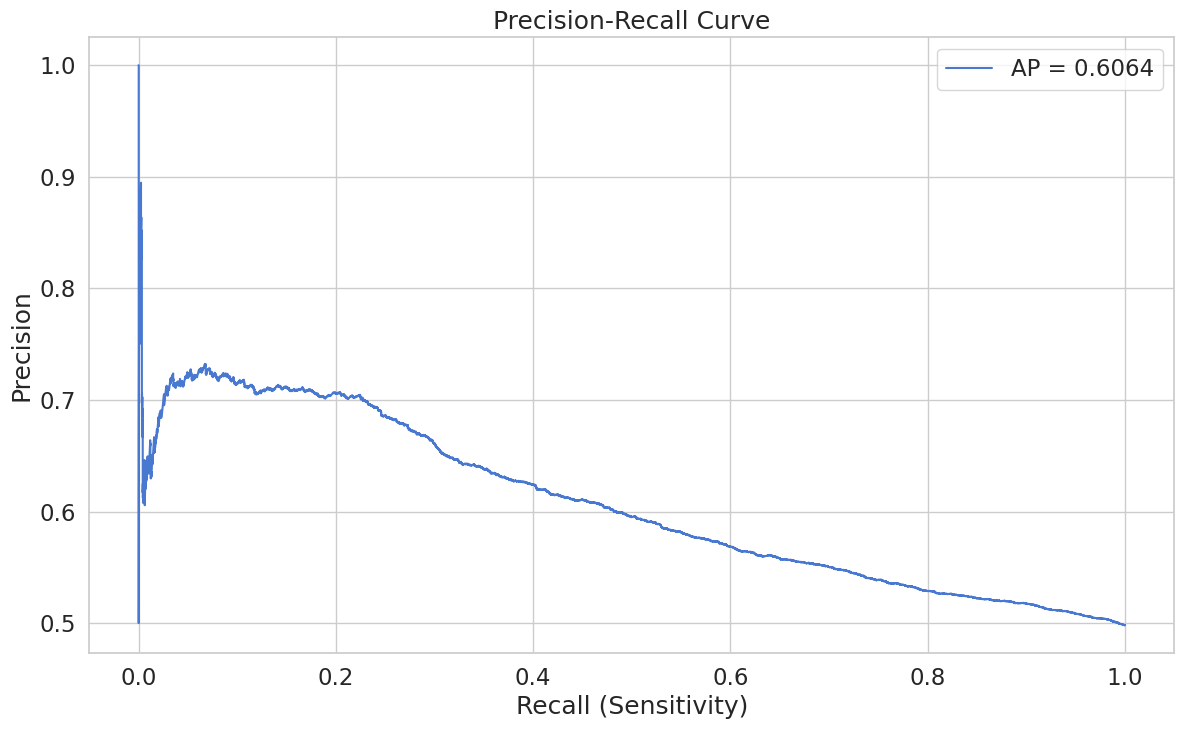

In [34]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Вычисление Precision, Recall и Thresholds
precision, recall, thresholds = precision_recall_curve(reconstructionErrorDF['cardio'], reconstructionErrorDF['pred_loss'])

# Вычисление среднего Precision (AP - Average Precision)
average_precision = average_precision_score(reconstructionErrorDF['cardio'], reconstructionErrorDF['pred_loss'])

# Построение графика
plt.plot(recall, precision, label='AP = %0.4f' % average_precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Интерпретация Precision-Recall кривой:

  Область под кривой (AP = 0.6064):
        Значение Average Precision (AP) = 0.6064 показывает средний уровень точности модели на всём диапазоне Recall.
        Значение выше 0.6 указывает на то, что модель имеет некоторую способность различать классы, но её эффективность нельзя назвать высокой.

  Форма кривой:
        Precision (точность) значительно снижается с ростом Recall (полноты). Это типично для моделей, где увеличение количества правильно классифицированных аномалий (Recall) приводит к увеличению ложных срабатываний, что снижает точность.
        Пики в начале кривой (на низких значениях Recall) говорят о том, что модель очень точна для небольшого числа предсказанных аномалий.

  Торговля между Precision и Recall:
        Наиболее высокий Precision достигается при низком Recall (меньше 0.2). Это значит, что модель хорошо предсказывает аномалии, но пропускает значительное количество случаев.
        При более высоком Recall (ближе к 1.0) Precision падает до ~0.5, что указывает на увеличение количества ложных срабатываний.

Используем threshold (порог) для разделения нормальных данных и аномалий на основе значения ошибки реконструкции (pred_loss)

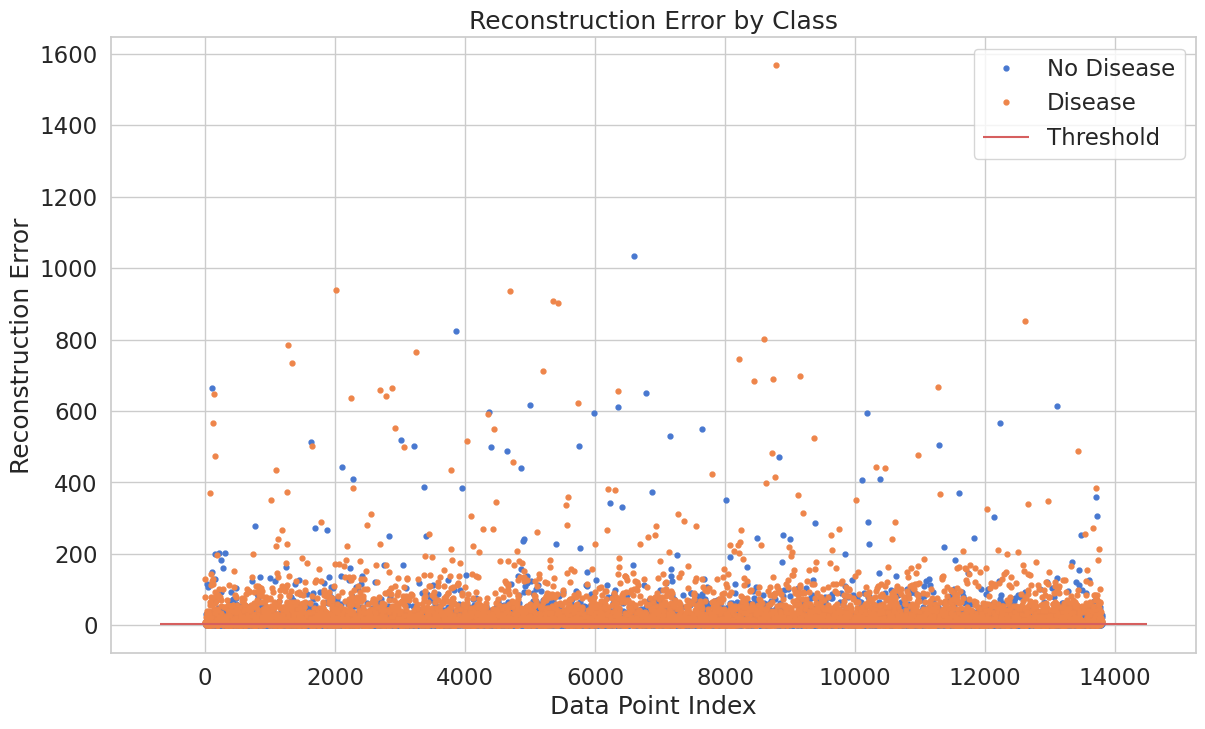

In [35]:
threshold = 2.9  # Задаём порог для ошибки реконструкции

# Группируем данные по классам (cardio)
groups = reconstructionErrorDF.groupby('cardio')

# Построение графика
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label="Disease" if name == 1 else "No Disease")

# Добавляем горизонтальную линию для порога
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Настройки графика
ax.legend()
plt.title("Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.grid(True)
plt.show()


Интерпретация графика:

  Распределение ошибок реконструкции по классам:
        Синие точки представляют данные без заболеваний (cardio = 0).
        Оранжевые точки представляют данные с заболеваниями (cardio = 1).
        Ошибки реконструкции для обоих классов сильно перекрываются, особенно в нижнем диапазоне.

  Линия порога (Threshold):
        Горизонтальная красная линия обозначает порог (threshold = 2.9), который используется для разделения классов.
        Данные с ошибками выше этой линии классифицируются как аномалии (cardio = 1), а ниже — как нормальные данные (cardio = 0).

  Особенности распределения:
        Большинство точек находится ниже линии порога, что говорит о том, что модель реконструировала данные с низкой ошибкой.
        Однако существуют данные с высокими ошибками реконструкции (особенно выше 200), которые модель явно считает аномальными.

  Перекрытие между классами:
        Видно, что ошибки реконструкции данных двух классов (cardio = 0 и cardio = 1) сильно пересекаются. Это указывает на сложности модели в разделении нормальных данных и аномалий.
        Такие перекрытия могут приводить к ложным срабатываниям (ошибочной классификации нормальных данных как аномалий) и пропущенным аномалиям.

## CONFUSION MATRIX

<ipython-input-36-bc4354b7ca13>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  annot=True, fmt="d", cmap=plt.cm.get_cmap('Blues'))


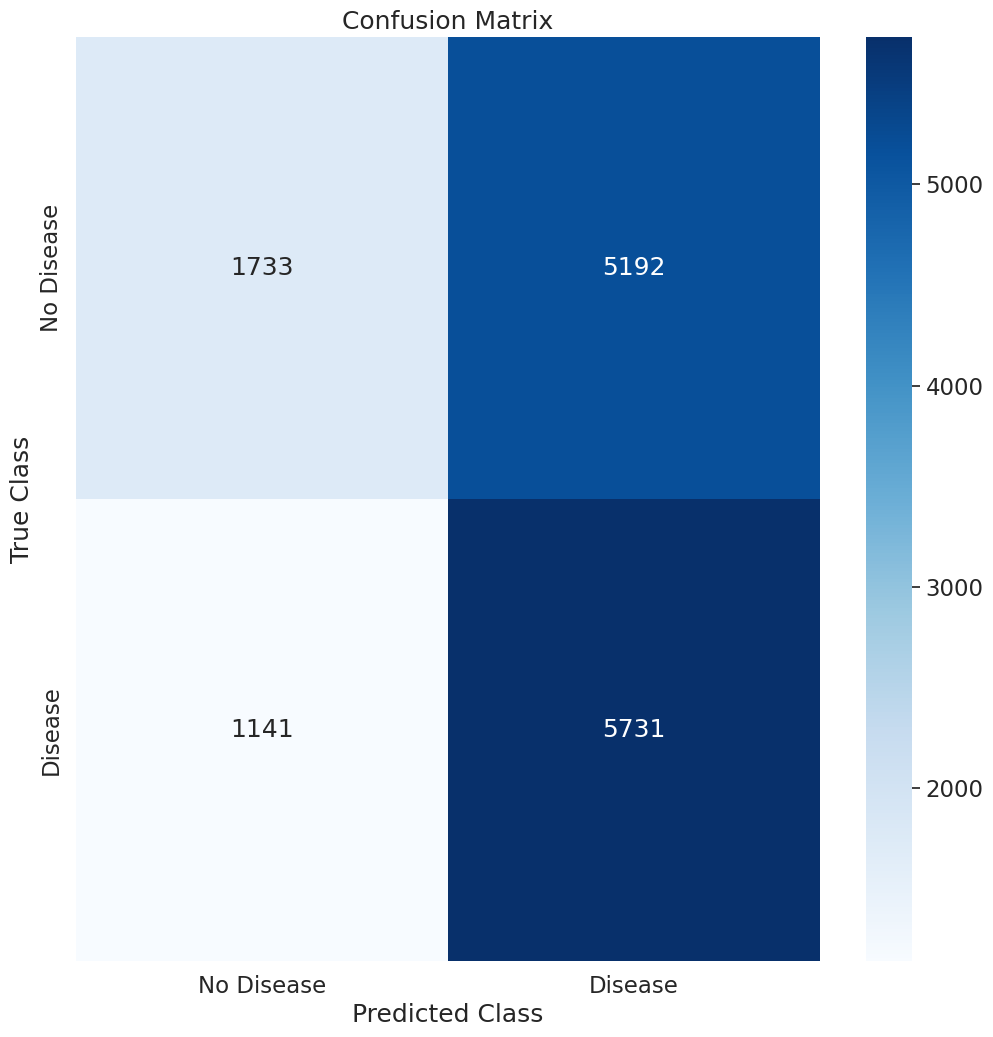

In [36]:
# Применение порога для предсказаний
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF['pred_loss'].values]

# Построение матрицы ошибок
conf_matrix = confusion_matrix(reconstructionErrorDF['cardio'], y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"],
            annot=True, fmt="d", cmap=plt.cm.get_cmap('Blues'))

plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


True Positives (TP): 5731

  Модель правильно классифицировала 5731 запись как "Disease" (болезнь).
  Это случаи, когда модель верно распознала заболевания.

True Negatives (TN): 1733

  Модель правильно классифицировала 1733 запись как "No Disease" (без болезни).
  Это случаи, когда модель верно распознала нормальные данные.

False Positives (FP): 5192

  Модель ошибочно классифицировала 5192 записи как "Disease", хотя они относятся к "No Disease".
  Это ложные срабатывания, которые снижают точность (Precision).

False Negatives (FN): 1141

  Модель ошибочно классифицировала 1141 запись как "No Disease", хотя они относятся к "Disease".
  Это пропущенные случаи заболеваний, что снижает полноту (Recall).

## Выводы


Результаты обучения модели:

    Модель продемонстрировала снижение ошибки реконструкции на протяжении эпох обучения, что свидетельствует о её способности извлекать ключевые признаки данных.
    Однако AUC (0.6096) и AP (0.6064) указывают на ограниченную способность модели различать классы, особенно в условиях, где данные классов перекрываются.

Анализ результатов:

    Графики распределения ошибок реконструкции показали, что данные классов имеют значительное перекрытие, что затрудняет их разделение.
    Матрица ошибок показала высокое количество ложных срабатываний (FP = 5192) при умеренном количестве пропущенных случаев заболевания (FN = 1141). Это указывает на необходимость оптимизации порога реконструкции или улучшения модели.

Проблемы модели:

    Высокое перекрытие ошибок между классами затрудняет эффективное разделение.
    Модель более склонна к ложным срабатываниям, что снижает её точность.
    Ограниченная архитектура автоэнкодера может быть недостаточно мощной для сложных зависимостей в данных.

Рекомендации:

    Провести оптимизацию порога реконструкции (threshold), чтобы найти баланс между точностью (Precision) и полнотой (Recall).
    Углублённая предобработка данных, включая удаление выбросов и масштабирование, может улучшить результаты.
    Увеличение сложности модели (например, добавление слоёв или изменение функции активации) может повысить её способность различать классы.
    Рассмотреть возможность использования других алгоритмов (например, рекуррентных сетей или гибридных подходов) для сравнения результатов.

Заключение:

    Построенная модель автоэнкодера демонстрирует базовую способность к классификации данных, но требует улучшений для реальных приложений.
    Представленные подходы и методы визуализации предоставляют хорошие инструменты для анализа и оптимизации моделей классификации.